In [367]:
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import random
import pprint

#TODO add temperature specifications
#TODO re order mof_to_row and gas_to_column as well as the reverse ones
#TODO henrys law coefficients and does the linear algebra

In [201]:
host = "adsorption.nist.gov"

## Creating a Dictionary that converts InChIKey to gas and hashkey to mof

In [202]:
##Creating a dictionary of gas names to InChIKey 
url = "https://" + host + "/isodb/api/gases.json"
bibliography = json.loads(requests.get(url).content)

gas_code = {}
for gas in bibliography:
    gas_code[gas['InChIKey']] = gas['name']

#Creates a dictionary for materials 
url = "https://" + host + "/isodb/api/materials.json"
bibliography = json.loads(requests.get(url).content)

material_code = {}
for material in bibliography:
    material_code[material['hashkey']] = material['name']

## Creates a Bar Graph of the types of categories in all of the Isotherms

The amount of uncategorized isotherms is 23090
The amount of epxerimental isotherms is 5723
The amount of mod isotherms is 460
The amount of qua isotherms is 118
The amount of simulated isotherms is 935


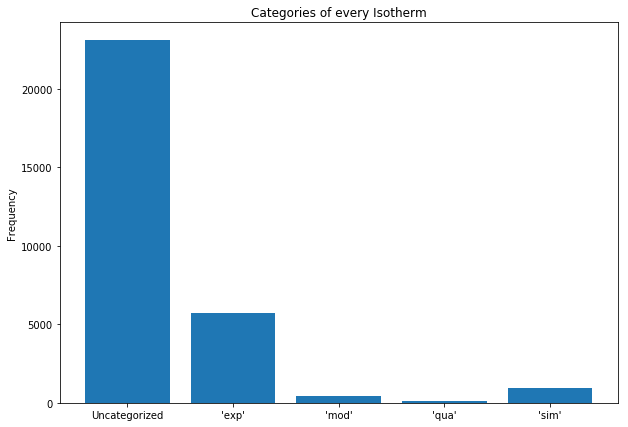

In [292]:
#Creating a bar graph to map the different types of categories of each isotherm
url = "https://" + host + "/isodb/api/isotherms.json"
isotherm_status = json.loads(requests.get(url).content)

isotherm_category = []
for isotherm in isotherm_status:
    isotherm_category.append(isotherm['category'])

uncategorized = isotherm_category.count('')
experimental = isotherm_category.count('exp')
mod = isotherm_category.count('mod')
qua = isotherm_category.count('qua')
simulated = isotherm_category.count('sim')

print('The amount of uncategorized isotherms is {}'.format(uncategorized))
print('The amount of epxerimental isotherms is {}'.format(experimental))
print('The amount of mod isotherms is {}'.format(mod))
print('The amount of qua isotherms is {}'.format(qua))
print('The amount of simulated isotherms is {}'.format(simulated))

objects = ("Uncategorized", "'exp'", "'mod'", "'qua'", "'sim'")
y_pos = np.arange(len(objects))
bar_height = [uncategorized, experimental, mod, qua, simulated]

plt.figure(figsize = (10,7))
plt.bar(y_pos, bar_height, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.title('Categories of every Isotherm')

plt.show()

## Importing all isotherm and taking out non experimental tests

In [204]:
url = "https://" + host + "/isodb/api/isotherms.json"
experimental_isotherm = json.loads(requests.get(url).content)
print("Number of isotherms before cutting non experimental: {}".format(len(experimental_isotherm)))

for isotherm in reversed(experimental_isotherm):
    if isotherm['category'] == 'exp' or isotherm['category'] == '':
        continue
    else:
        experimental_isotherm.remove(isotherm)

print("Number of isotherms after cutting non experimental: {}".format(len(experimental_isotherm)))

Number of isotherms before cutting non experimental: 30326
Number of isotherms after cutting non experimental: 28813


## Grabs units

In [205]:
#DO NOT RUN THIS UNLESS YOU HAVE 3 HOURs TO KILL but this does grab the units for the experimental isotherms
units = []
for isotherm in experimental_isotherm:
    filename = isotherm['filename']
    url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
    bibliography = json.loads(requests.get(url).content)
    units.append(bibliography['adsorptionUnits'])

## This takes out non viable units, mofs tested with a gas mixture, and numbers the gases and the mofs

In [281]:
viable_units = ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']
boolean_units_array = [x_i in viable_units for x_i in units]
boolean_isotherm_array = np.ones(len(experimental_isotherm),dtype = bool)

print("Number of Isotherms before cutting non viable units and gas mixtures: {}" .format(np.sum(boolean_isotherm_array)))

#Makes the boolean array false if the the units aren't viable or the gas is a mixture
for isotherm in range(len(experimental_isotherm)):
    if not boolean_units_array[isotherm]:
        boolean_isotherm_array[isotherm] = False
    elif len(experimental_isotherm[isotherm]['adsorbates']) > 1:
        boolean_isotherm_array[isotherm] = False
        
print("Number of Isotherms after cutting non viable units and gas mixtures: {}" .format(np.sum(boolean_isotherm_array)))

#TODO make temperature specifications for each of the isotherms, probably make another conditional statement about the temperature

#The below two for loops take every experimental mof and gas and number them 
count = 0
mof_to_row = {}
for isotherm in range(len(experimental_isotherm)):
    if boolean_isotherm_array[isotherm] and experimental_isotherm[isotherm]['adsorbent']['hashkey'] not in mof_to_row:
        mof_to_row[experimental_isotherm[isotherm]['adsorbent']['hashkey']] = count
        count += 1

row_to_mof = dict(map(reversed, mof_to_row.items())) #inverts the dictionary

count = 0
gas_to_column = {}
for isotherm in range(len(experimental_isotherm)):
    if boolean_isotherm_array[isotherm] and experimental_isotherm[isotherm]['adsorbates'][0]['InChIKey'] not in gas_to_column:
        gas_to_column[experimental_isotherm[isotherm]['adsorbates'][0]['InChIKey']] = count
        count += 1
        
column_to_gas = dict(map(reversed, gas_to_column.items())) #inverts the dictionary

print("Number of gases in the matrix: {}".format(len(gas_to_column)))
print("Number of mofs in the matrix: {}".format(len(mof_to_row)))

#Setting up a matrix of mofs and gases for available data and frequency of isotherms
mof_gas_matrix = np.zeros((len(mof_to_row),len(gas_to_column)))
mof_gas_frequency = np.zeros((len(mof_to_row),len(gas_to_column)))

Number of Isotherms before cutting non viable units and gas mixtures: 28813
Number of Isotherms after cutting non viable units and gas mixtures: 24710
Number of gases in the matrix: 103
Number of mofs in the matrix: 4542


## This fills in the matrix

In [285]:
#Now to fill in the matrix
for isotherm in range(len(experimental_isotherm)):
    if boolean_isotherm_array[isotherm]:
        row_value = mof_to_row[experimental_isotherm[isotherm]['adsorbent']['hashkey']]
        column_value = gas_to_column[experimental_isotherm[isotherm]['adsorbates'][0]['InChIKey']]
        mof_gas_matrix[row_value,column_value] = 1
        mof_gas_frequency[row_value,column_value] += 1

## Getting a visual on what the matrix looks like

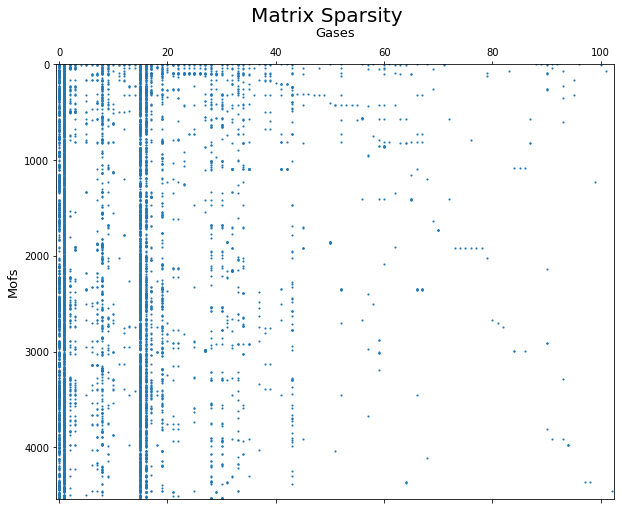

In [368]:
plt.figure(figsize = (10,8))
plt.spy(mof_gas_matrix,aspect = 'auto',markersize=1)
plt.suptitle('Matrix Sparsity',fontsize = 20)
plt.title('Gases',fontsize = 13)
plt.ylabel('Mofs',fontsize = 13)
plt.show()

## Checking to see if all gas mixtures were successfully "taken out" of experimental_isotherm

In [235]:
count=0
for isotherm in experimental_isotherm:
    if len(isotherm['adsorbates']) > 1:
        print(isotherm['filename'])
        print(boolean_isotherm_array[count])
    count += 1

10.1002aic.12397.Isotherm42
False
10.1002aic.12397.Isotherm45
False
10.1002aic.12397.Isotherm48
False
10.1002aic.12397.Isotherm51
False
10.1002aic.12397.Isotherm54
False
10.1007s104500079101x.Isotherm81
False
10.1007s104500079101x.Isotherm82
False
10.1007s104500079101x.Isotherm83
False
10.1007s104500079101x.Isotherm84
False
10.1007s104500079101x.Isotherm85
False
10.1007s104500079101x.Isotherm86
False
10.1007s1045001395272.Isotherm44
False
10.1007s1045001395272.Isotherm49
False
10.1007s1045001395272.Isotherm54
False
10.1007s1093401194945.Isotherm10
False
10.1007s1093401194945.Isotherm11
False
10.1007s1093401194945.Isotherm12
False
10.1007s1093401194945.Isotherm13
False
10.1007s1093401194945.Isotherm14
False
10.1007s1093401194945.Isotherm15
False
10.1007s1093401194945.Isotherm16
False
10.1007s1093401194945.Isotherm9
False
10.1016037838129387146r.Isotherm4
False
10.1016037838129387146r.Isotherm5
False
10.1016037838129387146r.Isotherm6
False
10.1016037838129387146r.Isotherm7
False
10.10160

## This takes a random value from the matrix to see if there is isotherm data on it and prints the isotherm data if present

In [353]:
count = 1
while True:
    gas_number = random.choice(range(len(gas_to_column)))
    mof_number = random.choice(range(len(mof_to_row)))
    if mof_gas_matrix[mof_number,gas_number] == 1:
        for isotherm in experimental_isotherm:
            if isotherm['adsorbent']['hashkey'] == row_to_mof[mof_number] and isotherm['adsorbates'][0]['InChIKey'] == column_to_gas[gas_number]:
                url = "https://adsorption.nist.gov/isodb/api/isotherm/" + isotherm['filename'] + ".json"
                bibliography = json.loads(requests.get(url).content)
                if bibliography['adsorptionUnits'] in viable_units and len(bibliography['adsorbates']) == 1 and isotherm['category'] == 'exp' or isotherm['category'] == '':
                    print('Isotherm ' + str(count) + ' satisfies all conditions!')
                #pprint.pprint(bibliography) <-- if you want to check the actual isotherm file
                count += 1
        break

Isotherm 1 satisfies all conditions!


## Another Check to see if the matrix is correct

In [280]:
#This just tests to see if the matrix is correct, you can see the amount of gases each isotherm has and compare it to the matrix
#material_code[experimental_isotherm[12]['adsorbent']['hashkey']] correspnds with the first term in the matrix 'CuBTC'
#Code should give 53 different gases that 'CuBTC' has been tested with because that is the number that the number of ones in the sparsity matrix

test_array=[]
for isotherm in range(len(experimental_isotherm)):
    if experimental_isotherm[isotherm]['adsorbent']['hashkey'] == experimental_isotherm[12]['adsorbent']['hashkey'] and boolean_isotherm_array[isotherm]:
        test_array.append(gas_code[experimental_isotherm[isotherm]['adsorbates'][0]['InChIKey']])

print('The gases that are tested with CuBTC:') 
pprint.pprint(set(test_array))
print('Number of gases in the list: {}'.format(len(set(test_array))))
print('Number of gasses in the first row of the matrix that corresponds with CuBTC: {}'.format(np.sum(mof_gas_matrix[0,:])))

The gases that are tested with CuBTC:
{'1-Butanol',
 '1-Octanol',
 '1-Propanol',
 '1-hexanol',
 '2-Methylbutane',
 '2-Propanol',
 'Acetone',
 'Acetonitrile',
 'Acetylene',
 'Ammonia',
 'Argon',
 'Benzene',
 'Carbon Dioxide',
 'Carbon Tetrachloride',
 'Carbon Tetrafluoride',
 'Carbon monoxide',
 'Cyclohexane',
 'Cyclopentane',
 'Deuterium',
 'Dichloromethane',
 'Dimethylforamide',
 'Ethane',
 'Ethanol',
 'Ethene',
 'Hydrogen',
 'Isobutane',
 'Isobutene',
 'Krypton',
 'M-Xylene',
 'Methane',
 'Methanol',
 'N-Butane',
 'N-Heptane',
 'N-Hexane',
 'N-Octane',
 'N-Pentane',
 'N-propane',
 'Nitric oxide',
 'Nitrogen',
 'Nitrogen Dioxide',
 'Nitrous Oxides',
 'O-Xylene',
 'Oxygen',
 'P-Xylene',
 'Propene',
 'Radon',
 'Sulfur dioxide',
 'Tetrahydrofuran',
 'Thiophene',
 'Toluene',
 'Trichloromethane',
 'Water',
 'Xenon'}
Number of gases in the list: 53
Number of gasses in the first row of the matrix that corresponds with CuBTC: 53.0


## This takes out rows and columns that have too little data

In [390]:
def prune_matrix(min_data_points):
    keep_row = np.ones(len(mof_to_row), dtype=bool)
    keep_column = np.ones(len(gas_to_column), dtype=bool)
    nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
    gases_cut = 0
    mofs_cut = 0
    count = 0

    while True:
        for i_row in range(len(mof_to_row)):
            if np.sum(mof_gas_matrix[i_row, keep_column]) < min_data_points:
                keep_row[i_row] = False

        for i_column in range(len(gas_to_column)):
            if np.sum(mof_gas_matrix[keep_row, i_column]) < min_data_points:
                keep_column[i_column] = False

        if nb_kept_rows_and_columns == (np.sum(keep_row) + np.sum(keep_column)):
            break

        nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
        count += 1

    mofs_cut = np.sum(~keep_row)
    gases_cut = np.sum(~keep_column)

    #TODO make another matrix that actually cuts the rows and the columns out

    print("Number of mofs cut: {}" .format(mofs_cut))
    print("Number of gases cut: {}" .format(gases_cut))
    print('The remaining dimensions of the matrix are {} by {}'.format(len(mof_to_row)-mofs_cut,len(gas_to_column)-gases_cut))
    print('The number of iterations of sparsing the matrix {}'.format(count))
    
    return keep_row, keep_column

keep_row, keep_column = prune_matrix(5)

Number of mofs cut: 4270
Number of gases cut: 56
The remaining dimensions of the matrix are 272 by 47
The number of iterations of sparsing the matrix 2


## Plotting the sparsed matrix and the original matrix side by side

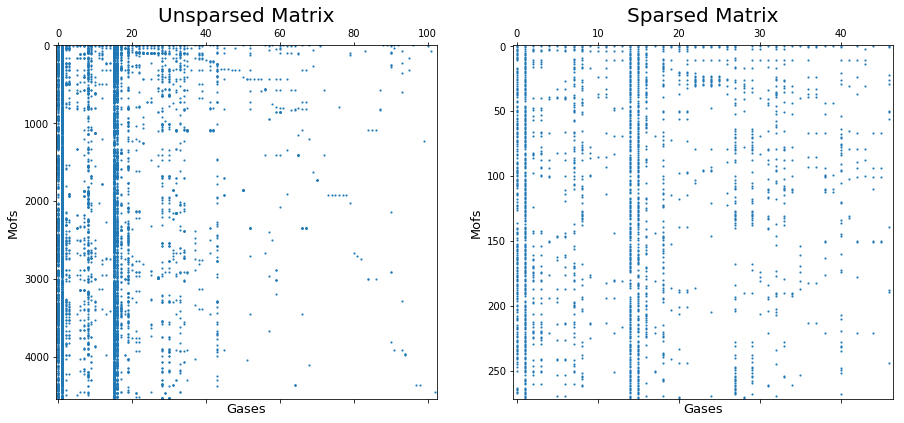

In [391]:
plt.figure(figsize = (15,6.5))

#subplot for the unsparsed matrix
plt.subplot(121)
plt.spy(mof_gas_matrix,aspect = 'auto',markersize=1)
plt.title('Unsparsed Matrix',fontsize = 20)
plt.xlabel('Gases',fontsize = 13)
plt.ylabel('Mofs',fontsize = 13)

#subplot the sparsed matrix 
plt.subplot(122)
plt.spy(mof_gas_matrix[keep_row,:][:,keep_column],aspect = 'auto',markersize=1)
plt.title('Sparsed Matrix',fontsize = 20)
plt.xlabel('Gases',fontsize = 13)
plt.ylabel('Mofs',fontsize = 13)
plt.show()

## Minimum data point requirement vs sparsity of matrix graph

In [384]:
mof_gas_matrix[keep_row,:][:,keep_column]

array([[1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

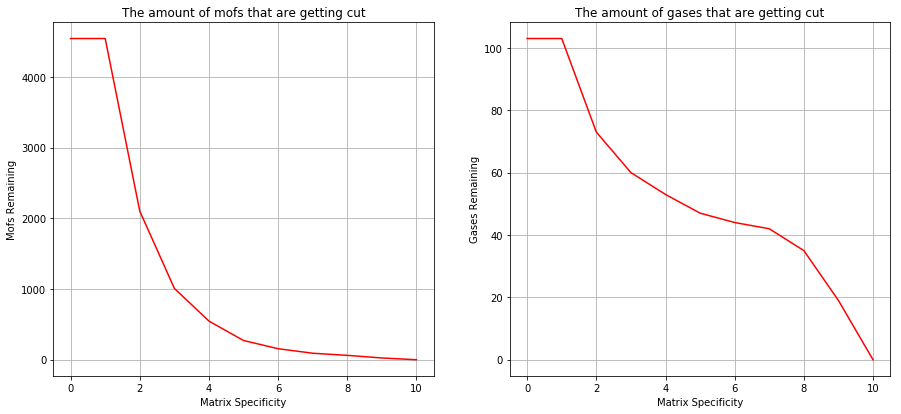

In [366]:
point_requirement_matrix = np.copy(mof_gas_matrix)
matrix_sum = np.sum(point_requirement_matrix)
gases_cut = 0
mofs_cut = 0
count = 0
cut_mofs = []
cut_gases = []

for n in range(11):
    while True:
        
        mofs_cut = 0
        gases_cut = 0
        
        for row in range(len(mof_to_row)):
            if np.sum(point_requirement_matrix[row,:]) < n:
                point_requirement_matrix[row,:] = False
        
        for column in range(len(gas_to_column)):
            if np.sum(point_requirement_matrix[:,column]) < n:
                point_requirement_matrix[:,column] = False
    
        if matrix_sum == np.sum(point_requirement_matrix):
            break
        
        matrix_sum = np.sum(point_requirement_matrix)
        count += 1
    
    for row in range(len(mof_to_row)):
        if point_requirement_matrix.sum(axis = 1)[row] == 0:
            mofs_cut += 1
    
    for column in range(len(gas_to_column)):
        if point_requirement_matrix.sum(axis = 0)[column] == 0:
            gases_cut += 1
            
    cut_mofs.append(len(mof_to_row) - mofs_cut)
    cut_gases.append(len(gas_to_column) - gases_cut)   

#Plots how the the gases and the mofs act with an increase in matrix specificity
n = range(11)
plt.figure(figsize = (15,6.5))

plt.subplot(121)
plt.plot(n,cut_mofs,'r')
plt.title('The amount of mofs that are getting cut')
plt.ylabel('Mofs Remaining')
plt.xlabel('Matrix Specificity')
plt.grid()

plt.subplot(122)
plt.plot(n,cut_gases,'r')
plt.title('The amount of gases that are getting cut')
plt.ylabel('Gases Remaining')
plt.xlabel('Matrix Specificity')
plt.grid()
plt.show()
#TODO plot the graphs as points

## Grabs individual isotherms

In [370]:
#Grabs each individual isotherm probably takes forever
individual_isotherms = []
for isotherm in experimental_isotherm:
    filename = isotherm['filename']
    url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
    bibliography = json.loads(requests.get(url).content)
    individual_isotherms.append(bibliography)

ConnectionError: HTTPSConnectionPool(host='adsorption.nist.gov', port=443): Max retries exceeded with url: /isodb/api/isotherm/10.1021acs.jced.6b00209.Isotherm15.json (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x0000025E2DB4E080>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))